# Training Bidirectional LSTM With Attention

In [1]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from sklearn.model_selection import train_test_split
import re
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import cleaned data

In [3]:
df = pd.read_csv("/content/drive/MyDrive/ML/rnn/Machine_Translation/Data/cleaned.csv")

In [4]:
df.tail()

,English,Marathi
41023,just saying you do not like fish because of th...,हड्डींमुळे मासे आवडत नाही असं म्हणणं हे काय मा...
41024,the japanese parliament today officially elect...,आज जपानी संसदेने अधिकृतरित्या र्‍यौतारौ हाशिमो...
41025,tom tried to sell his old vcr instead of throw...,टॉमने त्याचा जुना व्हीसीआर फेकून टाकण्याऐवजी व...
41026,you cannot view flash content on an ipad howev...,आयपॅडवर फ्लॅश आशय बघता येत नाही पण तुम्ही त्या...
41027,in roger miller recorded a song called you do...,मध्ये रॉजर मिलरने यू डोन्ट वॉन्ट माय लव्ह नावा...


**Note-** this dataset was cleaned in notebook1 [here](https://github.com/AdiShirsath/Neural-Machine-Translation/blob/master/EDA_And_Cleaning_Text.ipynb)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41028 entries, 0 to 41027
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  41028 non-null  object
 1   Marathi  41028 non-null  object
dtypes: object(2)
memory usage: 641.2+ KB


### Add start and end tokens to target sentecnes
* This helps model understand when sentence is started and ended
* Beause of this decoder can handle diff length sentence than encoder

In [6]:
df['Marathi'] =df.Marathi.apply(lambda x: 'sos '+ x + ' eos')

In [7]:
df.head()

,English,Marathi
0,go,sos जा eos
1,run,sos पळ eos
2,run,sos धाव eos
3,run,sos पळा eos
4,run,sos धावा eos


##### Convert to list for tokenizer

In [8]:

eng_texts = df.English.to_list()
mar_texts = df.Marathi.to_list()

## Tokenizer
* Converting into numbers

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
def tokenize_sent(text):
  '''
  Take list on texts as input and 
  returns its tokenizer and enocded text
  '''
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)

  return tokenizer, tokenizer.texts_to_sequences(text)



In [11]:
# Tokenize english and marathi sentences
eng_tokenizer, eng_encoded= tokenize_sent(text= eng_texts)
mar_tokenizer, mar_encoded= tokenize_sent(text= mar_texts)

#### English

In [12]:
eng_encoded[100:105]

[[1, 26, 1541], [18, 3, 591], [18, 3, 21], [18, 3, 21], [21, 130]]

In [13]:
eng_index_word = eng_tokenizer.index_word
eng_word_indec= eng_tokenizer.word_index


### Get vocab size which will be needed next

In [14]:
ENG_VOCAB_SIZE = len(eng_tokenizer.word_counts)+1
ENG_VOCAB_SIZE

5641

#### Mrathi

In [15]:
mar_encoded[30000:30005]

[[1, 190, 17, 2954, 45, 2],
 [1, 10307, 10308, 5956, 381, 150, 2],
 [1, 80, 986, 13, 46, 51, 217, 2],
 [1, 121, 52, 187, 260, 596, 2],
 [1, 40, 52, 187, 260, 596, 2]]

In [16]:
mar_index_word = mar_tokenizer.index_word
mar_word_index= mar_tokenizer.word_index


In [17]:
MAR_VOCAB_SIZE=len(mar_tokenizer.word_counts)+1
MAR_VOCAB_SIZE

13720

In [18]:
max_eng_len = 0
for i in range(len(eng_encoded)):
  if len(eng_encoded[i]) > max_eng_len:
    max_eng_len= len(eng_encoded[i])

max_mar_len = 0
for i in range(len(mar_encoded)):
  if len(eng_encoded[i]) > max_mar_len:
    max_mar_len= len(mar_encoded[i])


In [19]:
print(max_eng_len)
max_mar_len

36


37

## Padding
* Making input sentences as max length of input sentence with padding zero
* Same for target make them as max length of target sentence.

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
eng_padded = pad_sequences(eng_encoded, maxlen=max_eng_len, padding='post')
mar_padded = pad_sequences(mar_encoded, maxlen=max_mar_len, padding='post')


In [22]:
eng_padded

array([[  38,    0,    0, ...,    0,    0,    0],
       [ 399,    0,    0, ...,    0,    0,    0],
       [ 399,    0,    0, ...,    0,    0,    0],
       ...,
       [   4,  359,    6, ...,    0,    0,    0],
       [   2,   59, 2439, ...,    0,    0,    0],
       [  10, 3875, 3876, ...,   13,  366,  634]], dtype=int32)

In [23]:
mar_padded.shape

(41028, 37)

##### Converting to array

In [24]:
eng_padded= np.array(eng_padded)
mar_padded= np.array(mar_padded)

## Train test split

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(eng_padded, mar_padded, test_size=0.1, random_state=0)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36925, 36), (4103, 36), (36925, 37), (4103, 37))

## Building Model 

In [28]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate, Dropout
from tensorflow.keras import Input, Model

In [ ]:
### Import attention layer

In [29]:
os.chdir("/content/drive/MyDrive/ML/rnn/Machine_Translation/Attention")
from BahdanauAttention import AttentionLayer

In [30]:
# Encoder 

encoder_inputs = Input(shape=(max_eng_len,)) 
enc_emb = Embedding(ENG_VOCAB_SIZE, 1024)(encoder_inputs)

# Bidirectional lstm layer
enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)

final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

encoder_states =[final_enc_h, final_enc_c]

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(MAR_VOCAB_SIZE, 1024) 
dec_emb = dec_emb_layer(decoder_inputs)
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(512, return_sequences=True, return_state=True) 
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

#Attention Layer
attention_layer = AttentionLayer()
attention_result, attention_weights = attention_layer([encoder_outputs1, decoder_outputs])

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

#Dense layer
decoder_dense = Dense(MAR_VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 


In [31]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 1024)     5776384     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 36, 512), (N 2623488     embedding[0][0]                  
______________________________________________________________________________________________

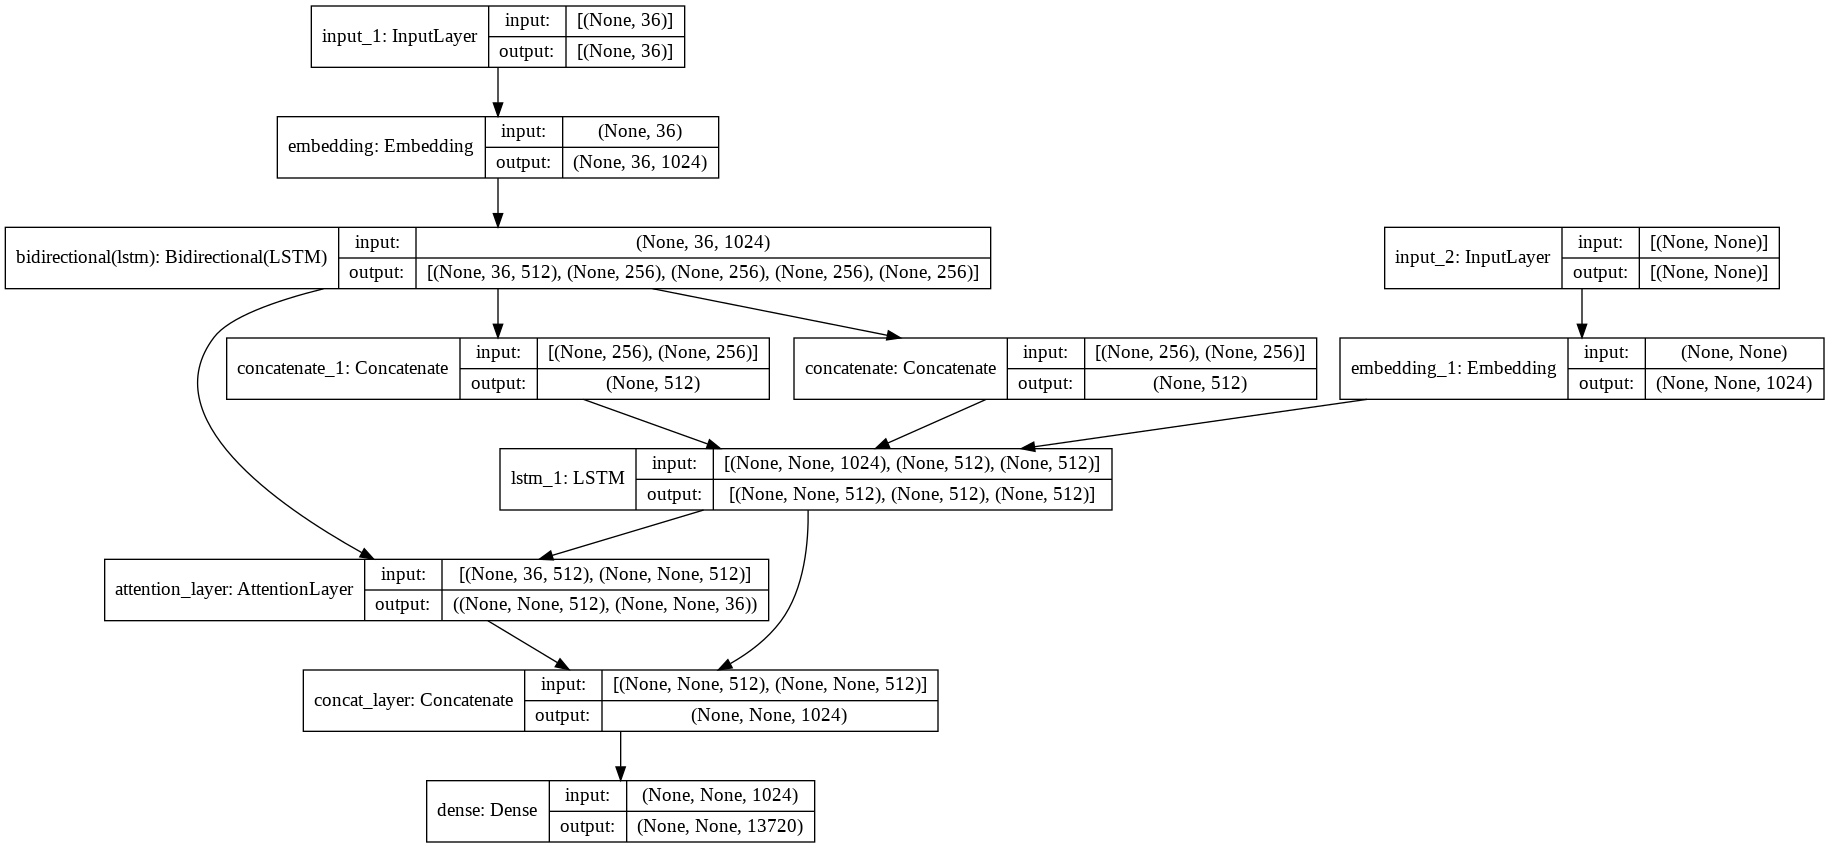

In [32]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

***IMP note :- if loss categorical crossentropy used then shapes incompatible error will occcur beause we have to use sparse_categorical_crossentropy when we have all different labels categorical is for mutliclass labels***

In [33]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Define callbacks

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/", monitor='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [35]:
# Training
encoder_input_data = X_train
# To make same as target data skip last number which is just padding
decoder_input_data = y_train[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_data =  y_train[:,1:]

# Testing
encoder_input_test = X_test
decoder_input_test = y_test[:,:-1]
decoder_target_test=  y_test[:,1:]

In [36]:
EPOCHS= 50 #@param {type:'slider',min:10,max:100, step:10 }

In [37]:
history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data, 
                    epochs=EPOCHS, 
                    batch_size=128,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    callbacks= callbacks_list)

Epoch 1/50
289/289 [==============================] - 150s 482ms/step - loss: 1.0627 - accuracy: 0.8686 - val_loss: 0.8411 - val_accuracy: 0.8797


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 2/50
289/289 [==============================] - 141s 488ms/step - loss: 0.7471 - accuracy: 0.8892 - val_loss: 0.6853 - val_accuracy: 0.8962


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 3/50
289/289 [==============================] - 142s 490ms/step - loss: 0.5679 - accuracy: 0.9072 - val_loss: 0.5365 - val_accuracy: 0.9135


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 4/50
289/289 [==============================] - 142s 491ms/step - loss: 0.3994 - accuracy: 0.9261 - val_loss: 0.4285 - val_accuracy: 0.9273


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 5/50
289/289 [==============================] - 143s 494ms/step - loss: 0.2692 - accuracy: 0.9428 - val_loss: 0.3683 - val_accuracy: 0.9369


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 6/50
289/289 [==============================] - 143s 494ms/step - loss: 0.1815 - accuracy: 0.9565 - val_loss: 0.3385 - val_accuracy: 0.9422


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 7/50
289/289 [==============================] - 143s 494ms/step - loss: 0.1283 - accuracy: 0.9667 - val_loss: 0.3239 - val_accuracy: 0.9459


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 8/50
289/289 [==============================] - 146s 504ms/step - loss: 0.0967 - accuracy: 0.9732 - val_loss: 0.3161 - val_accuracy: 0.9477


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 9/50
289/289 [==============================] - 146s 507ms/step - loss: 0.0777 - accuracy: 0.9776 - val_loss: 0.3147 - val_accuracy: 0.9487


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 10/50
289/289 [==============================] - 144s 498ms/step - loss: 0.0652 - accuracy: 0.9802 - val_loss: 0.3156 - val_accuracy: 0.9490


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 11/50
289/289 [==============================] - 144s 500ms/step - loss: 0.0565 - accuracy: 0.9822 - val_loss: 0.3151 - val_accuracy: 0.9505


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 12/50
289/289 [==============================] - 145s 501ms/step - loss: 0.0508 - accuracy: 0.9834 - val_loss: 0.3184 - val_accuracy: 0.9505


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 13/50
289/289 [==============================] - 145s 501ms/step - loss: 0.0465 - accuracy: 0.9844 - val_loss: 0.3211 - val_accuracy: 0.9504


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 14/50
289/289 [==============================] - 145s 501ms/step - loss: 0.0438 - accuracy: 0.9851 - val_loss: 0.3221 - val_accuracy: 0.9506


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 15/50
289/289 [==============================] - 145s 500ms/step - loss: 0.0418 - accuracy: 0.9854 - val_loss: 0.3228 - val_accuracy: 0.9500


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 16/50
289/289 [==============================] - 144s 499ms/step - loss: 0.0397 - accuracy: 0.9858 - val_loss: 0.3254 - val_accuracy: 0.9503


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 17/50
289/289 [==============================] - 144s 497ms/step - loss: 0.0385 - accuracy: 0.9860 - val_loss: 0.3286 - val_accuracy: 0.9503


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 18/50
289/289 [==============================] - 144s 498ms/step - loss: 0.0377 - accuracy: 0.9863 - val_loss: 0.3284 - val_accuracy: 0.9502


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


Epoch 19/50
289/289 [==============================] - 144s 498ms/step - loss: 0.0370 - accuracy: 0.9863 - val_loss: 0.3290 - val_accuracy: 0.9504


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1/assets


#### Saving weights is very important if ypu dont after colab session ends you might have to retrain model 

In [39]:
model.save_weights("/content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/saved_model/model1.h5")

#### After saving weight you can restart colab session without GPU 
Create model and
load model

In [34]:
model.load_weights("/content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/saved_model/model1.h5")

## Inference model
* For prediction we have to do this was because we trained encoder on input and decoder on target differently so we'll have to do same for prediction

In [35]:
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

decoder_state_h = Input(shape=(512,))
decoder_state_c = Input(shape=(512,))
decoder_hidden_state_input = Input(shape=(36,512))

dec_states = [decoder_state_h, decoder_state_c]

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

# Attention inference
attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])

decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

decoder_model= Model(
                    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

### Model will predict numbers and word at time so we'll have to convert them to words of language 

In [36]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)
  
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = mar_word_index['sos']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
            # convert max index number to marathi word
            sampled_char = mar_index_word[sampled_token_index]

        if (sampled_char!='end'):
            # aapend it ti decoded sent
            decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence.split()) >= 36):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        enc_h, enc_c = h, c
    
    return decoded_sentence

## Converting x and y back to words-sentences

In [37]:
def get_marathi_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0 :
        sentence =sentence +mar_index_word[i]+' '
    return sentence 

def get_english_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0:
        sentence =sentence +eng_index_word[i]+' '
    return sentence     

# Model results

In [46]:
len(X_test)

4103

#### Using simple loop we will take random 15 numbers from x_test and get results


In [59]:
for i in np.random.randint(10, 1000, size=15):
  print("English Sentence:",get_english_sentence(X_test[i]))
  print("Actual Marathi Sentence:",get_marathi_sentence(y_test[i])[4:-4])
  # Before passing input it has to be reshape as following
  print("Predicted Marathi Translation:",get_predicted_sentence(X_test[i].reshape(1,36))[:-4])
  print("----------------------------------------------------------------------------------------")

English Sentence: do i look fat in this dress 
Actual Marathi Sentence: मी हा ड्रेस घालून जाडी दिसते का 
Predicted Marathi Translation:  मी हा ड्रेस घालून जाडा दिसतो का
----------------------------------------------------------------------------------------
English Sentence: his father calls him tom 
Actual Marathi Sentence: त्यांचे वडील त्याला टॉम म्हणून हाक मारतात 
Predicted Marathi Translation:  त्याचे वडील त्याला टॉम म्हणून हाक मारतात
----------------------------------------------------------------------------------------
English Sentence: i think tom likes me 
Actual Marathi Sentence: मला वाटतं टॉमला मी आवडते 
Predicted Marathi Translation:  मला वाटतं टॉमला मी आवडतो
----------------------------------------------------------------------------------------
English Sentence: we have got three minutes 
Actual Marathi Sentence: आपल्याकडे तीन मिनिटं आहेत 
Predicted Marathi Translation:  आमच्याकडे तीन मिनिटं आहेत
----------------------------------------------------------------------------